### Making training dataset

1. bring on chemical and physical soil variables (*harmonized to 0-30cm per profile via mass preserving spline, mode, and categorical majority*)

2. extract vectors (soil type, lithology) per profile/sample site
3. extract rasters (bioclimatic, ecosystem type and DEM/terrain) per profile/sample site
4. merge into one training dataset by profile (or site_id)


In [1]:
## Load data from database

# === 1. Imports ===
import pandas as pd
from sqlalchemy import create_engine

# === 2. Connect to PostgreSQL ===
USER = "inesschwartz"
PASSWORD = "aa4862aa"
HOST = "localhost"
PORT = "5432"
DB = "soils_angola"

engine = create_engine(f"postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DB}")

# === 3. Load tables ===
analyses = pd.read_sql("SELECT * FROM analyses", engine)
morpho = pd.read_sql("SELECT * FROM morpho", engine)
usable_sites = pd.read_sql("SELECT * FROM usable_site_info", engine)
samples = pd.read_sql("SELECT * FROM samples", engine)


# Subset analyses, keep all morpho columns
analyses_subset = analyses.copy()
morpho_subset = morpho.copy()

# Filter only profiles present in site_info
valid_profiles = usable_sites['profile'].dropna().unique()
analyses_filtered = analyses_subset[analyses_subset['profile'].isin(valid_profiles)]
morpho_filtered = morpho_subset[morpho_subset['profile'].isin(valid_profiles)]

# Ensure merge keys have same dtype
analyses_filtered['sample_id'] = analyses_filtered['sample_id'].astype(str)
morpho_filtered['sample_id'] = morpho_filtered['sample_id'].astype(str)

# === 5. Merge analyses and morpho ===
combined_data = pd.merge(
    analyses_filtered,
    morpho_filtered,
    on=['profile', 'morpho_id'],
    how='inner',
    suffixes=('', '_morpho')
)

combined_data.head()

/var/folders/tp/79mdnyy56_xc3g1jvp9wf4_80000gn/T/ipykernel_9459/3803634425.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analyses_filtered['sample_id'] = analyses_filtered['sample_id'].astype(str)
/var/folders/tp/79mdnyy56_xc3g1jvp9wf4_80000gn/T/ipykernel_9459/3803634425.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpho_filtered['sample_id'] = morpho_filtered['sample_id'].astype(str)


,lab_sample_id,analysis_id,morpho_id,sample_id,profile,soil_biology_id,eg,thick_sand,fine_sand,silt,...,dry_chroma,moist_color_name,moist_hue,moist_value,moist_chroma,compaction,durability,friability,thick_contents_count,thick_contents_nature
0,458,Bg_113/57_4_1,Bg_113/57_4_1,5040,113_57,,59.0,42.9,13.1,10.9,...,6.0,,,,,,,,,
1,894,Bg_253/57_4_1,Bg_253/57_4_1,5456,253_57,,NaN,NaN,0.0,0.0,...,7.0,,,,,Irregularmente pouco compacto e medianamente c...,"Muito firme (com alguns torroes da mesma cor, ...",,Raro,Saibro quartzoso e de gres
2,7,B_109/62_1_1,B_109/62_1_1,11011,109_62,,1.0,15.3,48.5,17.6,...,2.0,Pardo-avermelhado,5YR,4.0,3.0,Pequena,Brando e brando a ligeiramente duro,,,
3,1549,Cb_20/59_3_1,Cb_20/59_3_1,7277,20_59,,NaN,NaN,NaN,NaN,...,6.0,Pardo-avermelhado,5YR,4.0,4.0,,,,,
4,5965,Mj_27/63_3_1,Mj_27/63_3_1,13391,27_63,,NaN,NaN,NaN,NaN,...,6.0,Laranja a pardo-avermelhado-escuro,5YR,4.0,6.0,Media a grande,Ligeiramente duro,,,


In [2]:
# === 6. Join with usable_sites ===
merged_final = pd.merge(
    combined_data,
    usable_sites,
    on='profile',
    how='inner'
)

# === 7. Optionally merge 'year' from samples ===
if 'sample_id' in samples.columns and 'year' in samples.columns:
    merged_final = pd.merge(
        merged_final,
        samples[['sample_id', 'year']],
        on='sample_id',
        how='left'
    )

merged_final.head()

,lab_sample_id,analysis_id,morpho_id,sample_id,profile,soil_biology_id,eg,thick_sand,fine_sand,silt,...,site_info_id,X_coord,Y_coord,district,geo_features_id,climate_id,topo_id,soil_type_id,geom,year
0,458,Bg_113/57_4_1,Bg_113/57_4_1,5040,113_57,,59.0,42.9,13.1,10.9,...,2400,14.624539,-13.315070,Benguela,197,197,197,112,0101000020E6100000000000A0C33F2D40000000E050A1...,1957.0
1,894,Bg_253/57_4_1,Bg_253/57_4_1,5456,253_57,,NaN,NaN,0.0,0.0,...,2045,15.001662,-12.341700,Benguela,1945,1945,1945,1194,0101000020E6100000000000E0D9002E4000000040F3AE...,1957.0
2,7,B_109/62_1_1,B_109/62_1_1,11011,109_62,,1.0,15.3,48.5,17.6,...,2523,16.778372,-13.896562,Bie,137,137,137,76,0101000020E61000000000006043C73040000000200ACB...,1962.0
3,1549,Cb_20/59_3_1,Cb_20/59_3_1,7277,20_59,,NaN,NaN,NaN,NaN,...,33,12.553629,-4.762017,Cabinda,1288,1288,1288,789,0101000020E610000000000040751B2940000000404E0C...,1959.0
4,5965,Mj_27/63_3_1,Mj_27/63_3_1,13391,27_63,,NaN,NaN,NaN,NaN,...,1060,17.135303,-9.595469,Malanje,2105,2105,2105,1289,0101000020E610000000000040A322314000000060E130...,1963.0


In [3]:
# List of columns to drop
cols_to_drop = [
    'geo_features_id',
    'climate_id',
    'topo_id',
    'soil_type_id',
    'geom',
    'field_sample_code',  
    'depth',
    'al',
    'si',
    'p',
    's',
    'cl',
    'ti',
    'cr',
    'mn',
    'fe',
    'co',
    'ni',
    'cu',
    'zn',
    'arsenic',
    'se',
    'rb',
    'sr',
    'zr',
    'nb',
    'mo',
    'cd',
    'sn',
    'sb',
    'ba',
    'ta',
    'w',
    'pt',
    'au',
    'hg',
    'tl',
    'pb',
    'bi',
    'th',
    'u'
]

# Drop these columns if they exist in the DataFrame
merged_final = merged_final.drop(columns=[col for col in cols_to_drop if col in merged_final.columns])

# Check the remaining columns
list(merged_final.columns)

['lab_sample_id',
 'analysis_id',
 'morpho_id',
 'sample_id',
 'profile',
 'soil_biology_id',
 'eg',
 'thick_sand',
 'fine_sand',
 'silt',
 'clay',
 'eq_hum',
 'atm_1/3',
 'atm_15',
 'caco3',
 'gypsum',
 'free_iron',
 'organic_carbon',
 'total_n',
 'p205',
 'organic_material',
 'ph_h2o',
 'ph_kcl',
 'Ca++',
 'Mg++',
 'Na+',
 'K+',
 'exchangable_bases_sum',
 'cec',
 'v',
 'conductivity',
 'soluble_sodium',
 'Min_<0,002',
 'Min_0,05-0,02',
 'Min_0,2-0,05',
 'Min_2-0,2',
 'porosity',
 'bulk_density',
 'sample_depth',
 'sample_id_morpho',
 'horizon_layer',
 'upper_depth',
 'lower_depth',
 'moisture_degree',
 'root_quantity',
 'root_diameter',
 'texture',
 'structure_type',
 'structure_class',
 'structure_degree',
 'pore_diameter',
 'pore_quantity',
 'pore_shape',
 'dry_color_name',
 'dry_hue',
 'dry_value',
 'dry_chroma',
 'moist_color_name',
 'moist_hue',
 'moist_value',
 'moist_chroma',
 'compaction',
 'durability',
 'friability',
 'thick_contents_count',
 'thick_contents_nature',
 'site

In [4]:
# Count unique years per profile
year_counts = merged_final.groupby('profile')['year'].nunique()

# Profiles with more than 1 year
multi_year_profiles = year_counts[year_counts > 1]

print(f"Number of profiles with multiple years: {len(multi_year_profiles)}")
print("Profiles with multiple years:")
print(multi_year_profiles)


Number of profiles with multiple years: 1
Profiles with multiple years:
profile
101A_58    2
Name: year, dtype: int64


In [5]:
## harmonize chem and physical samples to 1 depth (0-30)

import numpy as np
import pandas as pd
from scipy.interpolate import UnivariateSpline
from collections import Counter

# ------------------------------
# 1) Mass-preserving spline function (robust)
# ------------------------------
def fit_mpspline(depth_top, depth_bottom, values, lam=1.0, target_depths=[0,30]):
    depth_top = np.array(depth_top)
    depth_bottom = np.array(depth_bottom)
    values = np.array(values)
    
    # Remove NaNs
    mask = ~np.isnan(depth_top) & ~np.isnan(depth_bottom) & ~np.isnan(values)
    depth_top = depth_top[mask]
    depth_bottom = depth_bottom[mask]
    values = values[mask]
    
    n = len(values)
    if n == 0:
        return np.nan
    elif n == 1:
        # One horizon → just return the value
        return values[0]
    elif n == 2:
        # Two horizons → thickness-weighted average
        thickness = depth_bottom - depth_top
        return np.average(values, weights=thickness)
    
    # For 3+ horizons → spline
    midpoints = (depth_top + depth_bottom)/2
    sort_idx = np.argsort(midpoints)
    midpoints = midpoints[sort_idx]
    values = values[sort_idx]
    
    # Remove duplicate midpoints
    unique_midpoints, unique_indices = np.unique(midpoints, return_index=True)
    values = values[unique_indices]
    
    # Ensure spline order fits number of points
    k = min(3, len(values)-1)
    if k < 1:
        return np.nan
    
    spline = UnivariateSpline(unique_midpoints, values, s=lam, k=k)
    
    top, bottom = target_depths
    integral = spline.integral(top, bottom)
    return integral / (bottom - top)

# ------------------------------
# 2) Identify variable types
# ------------------------------
drop_cols = [
    'lab_sample_id','analysis_id','morpho_id','sample_id','sample_id_morpho','X_coord','Y_coord','profile',
    'upper_depth','lower_depth','sample_depth'
]

numeric_cols = merged_final.select_dtypes(include=np.number).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in drop_cols]

categorical_cols = merged_final.select_dtypes(include=['object','category']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in drop_cols]

# ------------------------------
# 3) Create harmonized dataset per profile
# ------------------------------
profiles = merged_final['profile'].unique()
harmonized_list = []

for pid in profiles:
    profile = merged_final[merged_final['profile'] == pid].copy()
    if profile.empty:
        continue
    
    profile_harmonized = {'profile': pid}
    
    # Numeric variables
    for col in numeric_cols:
        if col in ['organic_carbon','total_n','bulk_density']:
            profile_harmonized[col] = fit_mpspline(
                depth_top=profile['upper_depth'],
                depth_bottom=profile['lower_depth'],
                values=profile[col],
                lam=1.0,
                target_depths=[0,30]
            )
        else:
            thickness = profile['lower_depth'] - profile['upper_depth']
            valid_mask = ~profile[col].isna() & ~thickness.isna()
            if valid_mask.sum() > 0:
                profile_harmonized[col] = np.average(
                    profile[col][valid_mask], 
                    weights=thickness[valid_mask]
                )
            else:
                profile_harmonized[col] = np.nan
    
    # Categorical variables → mode
    for col in categorical_cols:
        vals = profile[col].dropna()
        if not vals.empty:
            profile_harmonized[col] = vals.mode().iloc[0]
        else:
            profile_harmonized[col] = np.nan
    
    # Metadata
    meta_cols = ['X_coord','Y_coord','district','year']
    for col in meta_cols:
        if col in profile.columns:
            profile_harmonized[col] = profile[col].iloc[0]
    
    harmonized_list.append(profile_harmonized)

# ------------------------------
# 4) Convert to DataFrame
# ------------------------------
profile_0_30cm = pd.DataFrame(harmonized_list)

print(f"Shape: {profile_0_30cm.shape} (profiles x variables)")


Shape: (1488, 63) (profiles x variables)


In [6]:
profile_0_30cm.head()

,profile,eg,thick_sand,fine_sand,silt,clay,eq_hum,atm_15,free_iron,organic_carbon,...,moist_chroma,compaction,durability,friability,thick_contents_count,thick_contents_nature,site_info_id,district,X_coord,Y_coord
0,113_57,31.933333,46.273684,15.352632,9.594737,28.800000,17.318182,NaN,1.646364,0.784545,...,,,,,,,2400,Benguela,14.624539,-13.315070
1,253_57,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,...,,Irregularmente pouco compacto e medianamente c...,"Muito firme (com alguns torroes da mesma cor, ...",,Raro,Saibro quartzoso e de gres,2045,Benguela,15.001662,-12.341700
2,109_62,11.200000,12.862500,37.752500,20.930000,28.447500,21.197500,9.4,2.283750,0.451160,...,6.0,Media,,,,,2523,Bie,16.778372,-13.896562
3,20_59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,,,,,,,33,Cabinda,12.553629,-4.762017
4,27_63,NaN,1.000000,45.318261,7.532174,46.117391,NaN,NaN,NaN,NaN,...,6.0,Media a grande,,,,,1060,Malanje,17.135303,-9.595469


In [7]:
import pandas as pd

# Identify rows where X_coord or Y_coord is NaN or 0.0
mask_problematic = (
    profile_0_30cm['X_coord'].isnull() |
    (profile_0_30cm['X_coord'] == 0.0) |
    profile_0_30cm['Y_coord'].isnull() |
    (profile_0_30cm['Y_coord'] == 0.0)
)

# Drop problematic rows
profile_0_30cm_clean = profile_0_30cm[~mask_problematic].copy()

# Optional: reset index
profile_0_30cm_clean.reset_index(drop=True, inplace=True)

# Report
print(f"Dropped {mask_problematic.sum()} problematic rows.")
print(f"Remaining rows: {len(profile_0_30cm_clean)}")


Dropped 18 problematic rows.
Remaining rows: 1470


In [8]:
# save csv
profile_0_30cm_clean.to_csv("/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/profile_0_30cm_clean.csv")

In [9]:
## check for outliers
numeric_cols = profile_0_30cm_clean.select_dtypes(include=['float64', 'int64']).columns
profile_0_30cm_clean[numeric_cols].describe()

,eg,thick_sand,fine_sand,silt,clay,eq_hum,atm_15,free_iron,organic_carbon,p205,...,ph_h2o,ph_kcl,cec,soluble_sodium,porosity,bulk_density,horizon_layer,year,X_coord,Y_coord
count,810.000000,1421.000000,1432.000000,1428.000000,1427.000000,1050.000000,474.000000,969.000000,1222.000000,519.000000,...,1343.000000,1201.000000,1228.000000,1209.000000,1470.000000,1469.000000,1470.000000,1258.000000,1470.000000,1470.000000
mean,6.085098,29.107481,36.787043,7.340589,26.248416,12.477576,9.915294,1.607833,0.718595,0.125318,...,5.895590,4.845484,7.585457,0.940503,0.423654,1.139545,3.650023,1960.686804,15.687077,-10.826322
std,9.348117,19.580898,16.658748,7.018562,16.680387,10.399102,6.676489,2.280296,0.641336,0.431893,...,0.974398,0.864960,8.141821,4.928937,0.133892,0.378345,0.866966,3.175157,2.281815,3.059532
min,0.000000,0.123158,0.000000,0.000000,0.000000,-17.445455,-24.909091,0.010000,0.000000,0.010000,...,4.072432,3.500000,-33.628182,-3.542857,0.000000,-3.643750,1.000000,1946.000000,12.035000,-17.998255
25%,1.000000,12.038636,23.693021,2.443800,12.933797,3.128730,4.238039,0.475000,0.336770,0.040000,...,5.226803,4.266993,3.428060,0.000000,0.390097,1.069746,3.000000,1958.000000,14.033020,-12.960744
50%,2.546777,27.752941,35.151536,5.191116,24.185714,11.865909,9.496753,1.045902,0.566277,0.056000,...,5.636842,4.574118,5.386707,0.000000,0.449443,1.215748,3.687228,1961.000000,15.402227,-10.912705
75%,6.265941,44.138000,48.233552,9.741449,37.336546,19.796517,13.950725,2.038446,0.904860,0.080791,...,6.215917,5.156364,9.017181,0.000000,0.490598,1.341986,4.236154,1963.000000,16.864203,-8.882544
max,61.000000,89.694118,88.894118,48.675000,82.800000,56.355882,29.000000,52.366667,7.581768,6.100000,...,9.400000,8.660000,171.124500,64.857143,2.650000,2.591714,6.772358,1967.000000,23.962458,-4.446332


In [10]:
#IQR method
Q1 = profile_0_30cm_clean[numeric_cols].quantile(0.25)
Q3 = profile_0_30cm_clean[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

outliers = ((profile_0_30cm_clean[numeric_cols] < (Q1 - 1.5 * IQR)) | 
            (profile_0_30cm_clean[numeric_cols] > (Q3 + 1.5 * IQR)))


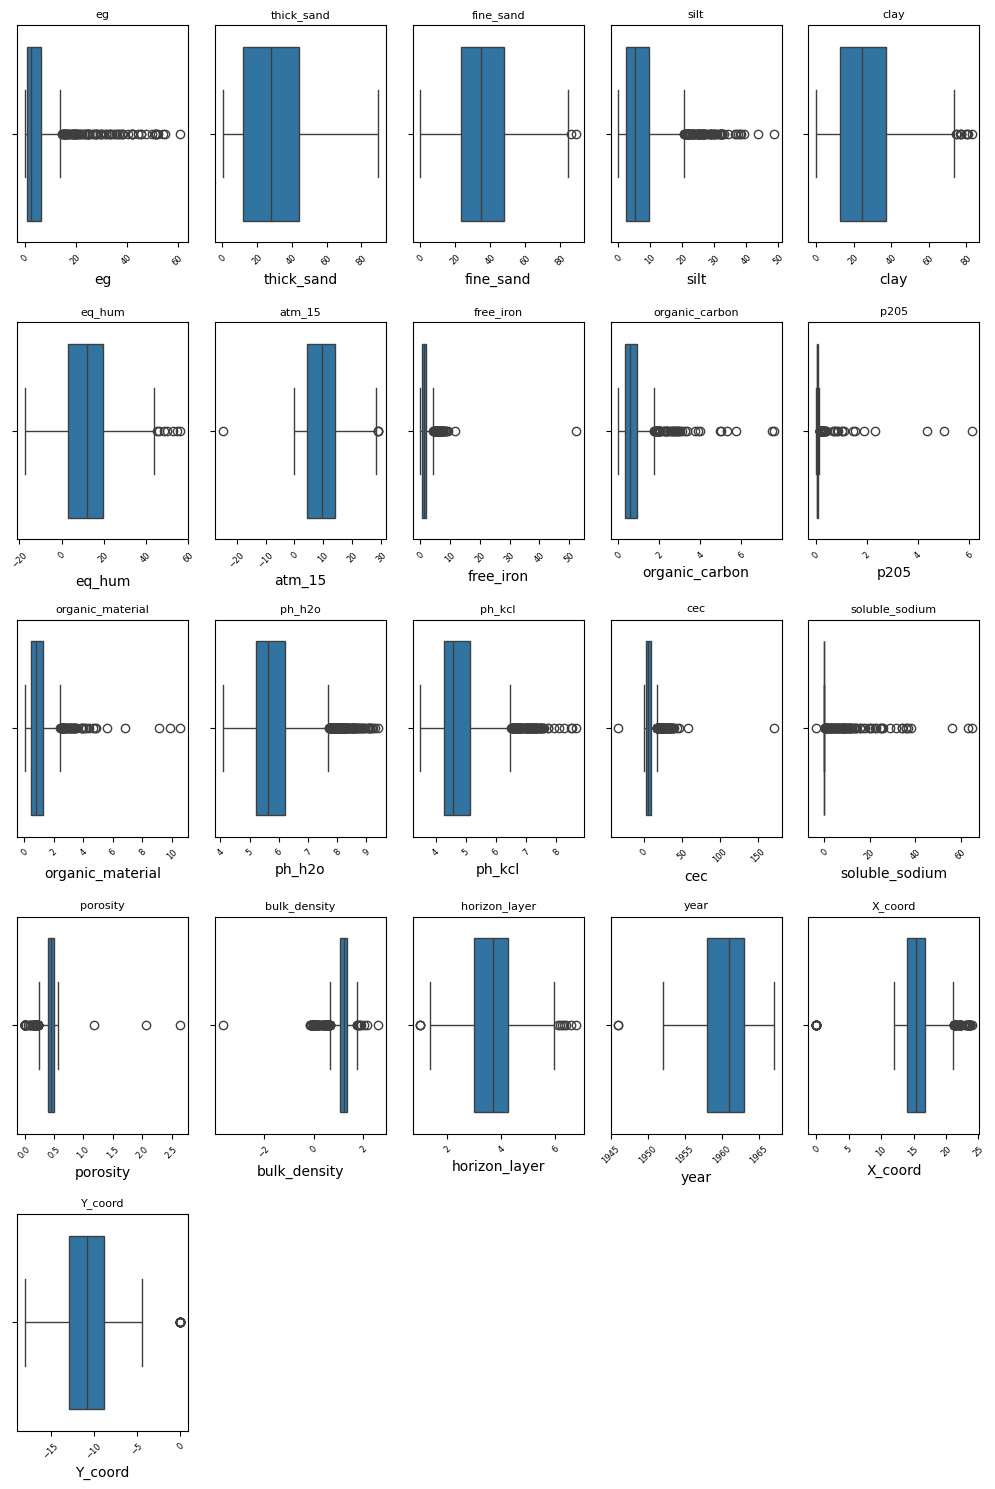

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure with multiple subplots
num_vars = len(numeric_cols)
cols_per_row = 5  # number of boxplots per row
rows = (num_vars + cols_per_row - 1) // cols_per_row

fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row*2, rows*3))
axes = axes.flatten()  # flatten in case of multiple rows

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=profile_0_30cm[col], ax=axes[i])
    axes[i].set_title(col, fontsize=8)
    axes[i].tick_params(axis='x', labelrotation=45, labelsize=6)

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [12]:
import pandas as pd

# Select only numeric columns
numeric_cols = profile_0_30cm_clean.select_dtypes(include=['float64', 'int64']).columns

# Calculate Q1, Q3 and IQR
Q1 = profile_0_30cm_clean[numeric_cols].quantile(0.25)
Q3 = profile_0_30cm_clean[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

# Loop through each numeric column and find outliers
outlier_dict = {}

for col in numeric_cols:
    outlier_rows = profile_0_30cm_clean[(profile_0_30cm_clean[col] < (Q1[col] - 1.5 * IQR[col])) |
                                   (profile_0_30cm_clean[col] > (Q3[col] + 1.5 * IQR[col]))]
    if not outlier_rows.empty:
        outlier_dict[col] = outlier_rows.index.tolist()

# Print summary
for col, rows in outlier_dict.items():
    print(f"Column '{col}' has {len(rows)} outlier(s) in rows: {rows}")

# Optional: create a dataframe of all outlier rows
#all_outliers = profile_0_30cm.loc[set(sum(outlier_dict.values(), []))]


Column 'eg' has 87 outlier(s) in rows: [0, 111, 118, 120, 122, 125, 126, 135, 173, 183, 187, 194, 196, 198, 199, 202, 205, 207, 208, 212, 214, 219, 223, 226, 231, 236, 237, 238, 239, 244, 253, 301, 304, 366, 374, 410, 463, 471, 486, 490, 491, 509, 519, 545, 566, 568, 606, 699, 703, 711, 712, 713, 715, 716, 717, 722, 735, 736, 775, 785, 813, 814, 816, 843, 848, 861, 865, 960, 1012, 1053, 1086, 1189, 1280, 1281, 1284, 1285, 1289, 1293, 1299, 1301, 1303, 1310, 1317, 1373, 1418, 1459, 1467]
Column 'fine_sand' has 2 outlier(s) in rows: [873, 1013]
Column 'silt' has 87 outlier(s) in rows: [2, 20, 124, 136, 139, 140, 141, 142, 148, 151, 156, 162, 168, 191, 243, 248, 347, 349, 351, 358, 359, 442, 483, 488, 503, 504, 506, 507, 512, 513, 521, 523, 531, 532, 551, 553, 567, 570, 579, 590, 595, 603, 655, 807, 839, 843, 909, 978, 988, 1017, 1033, 1037, 1060, 1129, 1140, 1144, 1151, 1155, 1157, 1164, 1168, 1173, 1176, 1185, 1191, 1192, 1197, 1200, 1203, 1204, 1208, 1209, 1212, 1215, 1264, 1317, 1319,

In [13]:
## remove nulls from usable_site_info

import geopandas as gpd
import pandas as pd

# --- Input paths ---
points_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/usable_site_info_epsg32733.gpkg"
points = gpd.read_file(points_path)

# View the first few rows
points.head()





,site_info_id,profile,X_coord,Y_coord,district,geo_features_id,climate_id,topo_id,soil_type_id,geometry
0,2770,1_57,12.161278,-15.222598,Namibe,1,1,1,2,POINT (195025.855 8315068.542)
1,48,1_59,12.575774,-4.866985,Cabinda,2,2,2,3,POINT (231130.92 9461556.108)
2,881,1_63,17.081955,-9.274587,Malanje,4,4,4,4,POINT (728708.838 8974120.144)
3,2675,10_54,14.445188,-14.922688,Huila,9,9,9,5,POINT (440331.329 8350150.683)
4,2698,10_55,13.455059,-14.977228,Huila,10,10,10,6,POINT (333872.184 8343613.735)


In [14]:
# Quick stats to see if there are any zeros
points.describe()

,X_coord,Y_coord,geo_features_id,climate_id,topo_id
count,1488.000000,1488.000000,1488.000000,1488.000000,1488.000000
mean,15.539367,-10.720157,2101.275538,2101.275538,2101.275538
std,2.731417,3.220762,1239.710802,1239.710802,1239.710802
min,0.000000,-17.998255,1.000000,1.000000,1.000000
25%,13.959387,-12.935900,1020.750000,1020.750000,1020.750000
50%,15.374377,-10.848000,2071.000000,2071.000000,2071.000000
75%,16.841054,-8.826534,3097.250000,3097.250000,3097.250000
max,23.962458,0.000000,4320.000000,4320.000000,4320.000000


In [15]:
import geopandas as gpd

points_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/usable_site_info_epsg32733.gpkg"
points = gpd.read_file(points_path)

# Count rows where X_coord or Y_coord are 0.0
zero_count = points[(points["X_coord"] == 0.0) | (points["Y_coord"] == 0.0)].shape[0]

# Count rows where X_coord or Y_coord are NaN
na_count = points[points["X_coord"].isna() | points["Y_coord"].isna()].shape[0]

# Combine both conditions
total_null_coords = points[(points["X_coord"].isna()) | 
                           (points["Y_coord"].isna()) | 
                           (points["X_coord"] == 0.0) | 
                           (points["Y_coord"] == 0.0)].shape[0]

print(f"Rows with zero coordinates: {zero_count}")
print(f"Rows with NaN coordinates: {na_count}")
print(f"Total rows with null/zero coordinates: {total_null_coords}")


Rows with zero coordinates: 14
Rows with NaN coordinates: 0
Total rows with null/zero coordinates: 14


In [16]:
import geopandas as gpd

# Load your GeoPackage
points_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/usable_site_info_epsg32733.gpkg"
points = gpd.read_file(points_path)

# Drop rows where X_coord or Y_coord are 0.0 or NaN
points_clean = points[~((points["X_coord"].isna()) | 
                        (points["Y_coord"].isna()) | 
                        (points["X_coord"] == 0.0) | 
                        (points["Y_coord"] == 0.0))]

# Optional: check the number of rows remaining
print(f"Rows before cleaning: {len(points)}")
print(f"Rows after cleaning: {len(points_clean)}")

# Save cleaned GeoPackage
output_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/usable_site_info_epsg32733_clean.gpkg"
points_clean.to_file(output_path, layer="usable_site_info", driver="GPKG")


Rows before cleaning: 1488
Rows after cleaning: 1474


## Extract soil data and lithology from .tif to csv per profile

In [17]:
import geopandas as gpd
import pandas as pd
import os
import re  # for regex

# --- Input paths ---
points_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/usable_site_info_epsg32733_clean.gpkg"
soil_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/angola_soil_data2_32733.gpkg"
lithology_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/lithology2.gpkg"


# --- Load data ---
points = gpd.read_file(points_path)
soil = gpd.read_file(soil_path)[["FAOSOIL", "DOMSOI", "faosoil_id", "geometry"]]
lithology = gpd.read_file(lithology_path)[["africa_lithology_90m.img.vat_lithology", "geometry"]]

# --- Ensure CRS matches ---
if points.crs != soil.crs:
    soil = soil.to_crs(points.crs)
if points.crs != lithology.crs:
    lithology = lithology.to_crs(points.crs)

# --- Spatial join ---
points_soil = gpd.sjoin(points, soil, how="left", predicate="intersects")

# Drop index_right from first join
if "index_right" in points_soil.columns:
    points_soil = points_soil.drop(columns=["index_right"])

points_soil_lith = gpd.sjoin(points_soil, lithology, how="left", predicate="intersects")

# Drop index_right from second join
if "index_right" in points_soil_lith.columns:
    points_soil_lith = points_soil_lith.drop(columns=["index_right"])

# --- Remove numbers from lithology column ---
# Example: "1. Carbonate" → "Carbonate"
points_soil_lith["africa_lithology_90m.img.vat_lithology"] = points_soil_lith[
    "africa_lithology_90m.img.vat_lithology"
].apply(lambda x: re.sub(r"^\d+\.\s*", "", str(x)))

# Drop multiple columns
points_soil_lith_clean = points_soil_lith
points_soil_lith_clean = points_soil_lith_clean.drop(columns=["geo_features_id", "climate_id", "topo_id", "soil_type_id"])
points_soil_lith_clean = points_soil_lith_clean.drop(columns=["geometry"])

# --- Save clean CSV ---
output_csv = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/soil_samples_with_vector_clean.csv"
points_soil_lith_clean.to_csv(output_csv, index=False)

print("✅ CSV saved at:", output_csv)

✅ CSV saved at: /Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/soil_samples_with_vector_clean.csv


In [18]:
points_soil_lith_clean.columns

Index(['site_info_id', 'profile', 'X_coord', 'Y_coord', 'district', 'FAOSOIL',
       'DOMSOI', 'faosoil_id', 'africa_lithology_90m.img.vat_lithology'],
      dtype='object')

In [19]:
# Count unique profiles
n_profiles1 = points_soil_lith_clean['profile'].nunique()
print(f"Unique profiles: {n_profiles1}")

Unique profiles: 1474


In [20]:
points_soil_lith_clean.head(2)

,site_info_id,profile,X_coord,Y_coord,district,FAOSOIL,DOMSOI,faosoil_id,africa_lithology_90m.img.vat_lithology
0,2770,1_57,12.161278,-15.222598,Namibe,Yk23-1/2a,Yk,131.0,Carbonate
1,48,1_59,12.575774,-4.866985,Cabinda,Qf36-1a,Qf,112.0,Non-Carbonate


## Extract the landsurfaceforms raster values per profile

In [21]:
import rasterio
import geopandas as gpd
import pandas as pd

# --- Load your points ---
points_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/usable_site_info_epsg32733_clean.gpkg"
points = gpd.read_file(points_path)

# --- Load your raster ---
raster_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/landsurfaceforms/landsurfaceforms.tif"
raster = rasterio.open(raster_path)

# --- Ensure points are in the same CRS as the raster ---
if points.crs != raster.crs:
    points = points.to_crs(raster.crs)

# --- Extract raster values at point locations ---
coords = [(x, y) for x, y in zip(points.geometry.x, points.geometry.y)]
points['landsurface_value'] = [val[0] for val in raster.sample(coords)]

# --- Optional: convert codes to descriptive categories ---
landsurface_lookup = {
    1: "smooth_plains",
    2: "irregular_plains",
    3: "escarpments",
    4: "hills",
    5: "breaks",
    6: "low_mountains",
    7: "high_mountains/deep_canyons"
}
points['landsurface_label'] = points['landsurface_value'].map(landsurface_lookup)

# --- Define your working DataFrame ---
landsurface_points = points.copy()

# --- Drop unnecessary columns ---
drop_cols = ["geo_features_id", "climate_id", "topo_id", "soil_type_id"]
landsurface_points_clean = landsurface_points.drop(columns=drop_cols, errors="ignore")

# --- Save to CSV ---
output_csv = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/landsurface_sample_points.csv"
landsurface_points_clean.drop(columns='geometry').to_csv(output_csv, index=False)

print("CSV saved at:", output_csv)


CSV saved at: /Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/landsurface_sample_points.csv


In [22]:
print(f"Shape: {landsurface_points_clean.shape} (profiles x variables)")
landsurface_points_clean.head()

Shape: (1474, 8) (profiles x variables)


,site_info_id,profile,X_coord,Y_coord,district,geometry,landsurface_value,landsurface_label
0,2770,1_57,12.161278,-15.222598,Namibe,POINT (195025.855 8315068.542),1,smooth_plains
1,48,1_59,12.575774,-4.866985,Cabinda,POINT (231130.92 9461556.108),5,breaks
2,881,1_63,17.081955,-9.274587,Malanje,POINT (728708.838 8974120.144),2,irregular_plains
3,2675,10_54,14.445188,-14.922688,Huila,POINT (440331.329 8350150.683),1,smooth_plains
4,2698,10_55,13.455059,-14.977228,Huila,POINT (333872.184 8343613.735),2,irregular_plains


## extract the ecosystem raster values per profile

In [23]:
import rasterio
import geopandas as gpd
import pandas as pd
from dbfread import DBF

# --- Load your points ---
points_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/usable_site_info_epsg32733_clean.gpkg"
ecosystems_points = gpd.read_file(points_path)

# --- Load raster (ecosystem.tif) ---
ecosyst_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/labelled_ecosystems32733.tif"
raster = rasterio.open(ecosyst_path)

# --- Ensure CRS match ---
if ecosystems_points.crs != raster.crs:
    ecosystems_points = ecosystems_points.to_crs(raster.crs)

# --- Extract raster values (band 1) ---
coords = [(x, y) for x, y in zip(ecosystems_points.geometry.x, ecosystems_points.geometry.y)]
ecosystems_points['eco_value'] = [val[0] for val in raster.sample(coords)]

# --- Read the VAT (.dbf) ---
vat_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_raw/Africa Terrestrial Ecosystems/africa_labeledecosystems_90m/africa_labeledecosystems_90m.tif.vat.dbf"
vat_records = DBF(vat_path, load=True)
vat_df = pd.DataFrame(iter(vat_records))

# --- Build lookup tables ---
subclass_lookup = dict(zip(vat_df['Value'], vat_df['subclass']))
class_lookup    = dict(zip(vat_df['Value'], vat_df['class']))
division_lookup = dict(zip(vat_df['Value'], vat_df['Division']))

# --- Map values to labels ---
ecosystems_points['eco_subclass'] = ecosystems_points['eco_value'].map(subclass_lookup)
ecosystems_points['eco_class']    = ecosystems_points['eco_value'].map(class_lookup)
ecosystems_points['eco_division'] = ecosystems_points['eco_value'].map(division_lookup)

# --- Check for unmatched raster codes ---
unique_raster_vals = set(ecosystems_points['eco_value'].unique())
vat_vals = set(vat_df['Value'].unique())
missing = unique_raster_vals - vat_vals

print("Unique raster values in points:", sorted(unique_raster_vals))
print("Unique VAT values:", sorted(vat_vals)[:20], "...")
print("Missing values (in raster but not in VAT):", missing)

Unique raster values in points: [-2147483648, 0, 1, 3, 4, 66, 67, 89, 96, 97, 98, 113, 116, 118, 123, 143, 157, 200, 202, 204, 211, 216, 236, 246, 602]
Unique VAT values: [0, 1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 21, 27, 51, 52, 61] ...
Missing values (in raster but not in VAT): {-2147483648}


In [24]:
## Map numeric codes to labels

# --- Assume your DataFrame is called ecosystems_points ---

# 1) Clean the leading numeric codes
ecosystems_points['eco_subclass_clean'] = ecosystems_points['eco_subclass'].str.replace(r'^\S+\s+', '', regex=True)
ecosystems_points['eco_class_clean']    = ecosystems_points['eco_class'].str.replace(r'^\S+\s+', '', regex=True)
ecosystems_points['eco_division_clean'] = ecosystems_points['eco_division'].str.replace(r'^\S+\s+', '', regex=True)

# 2) Convert cleaned columns to categorical codes for modeling
ecosystems_points['eco_subclass_code'] = ecosystems_points['eco_subclass_clean'].astype('category').cat.codes
ecosystems_points['eco_class_code']    = ecosystems_points['eco_class_clean'].astype('category').cat.codes
ecosystems_points['eco_division_code'] = ecosystems_points['eco_division_clean'].astype('category').cat.codes

# 3) Optional: keep a mapping dictionary to decode later
subclass_mapping = dict(enumerate(ecosystems_points['eco_subclass_clean'].astype('category').cat.categories))
class_mapping    = dict(enumerate(ecosystems_points['eco_class_clean'].astype('category').cat.categories))
division_mapping = dict(enumerate(ecosystems_points['eco_division_clean'].astype('category').cat.categories))


In [25]:
# output: cleaned and coded categorical variables
# --- Drop unnecessary columns ---
drop_cols = ["geo_features_id", "climate_id", "topo_id", "soil_type_id", "geometry", "eco_subclass", "eco_division", "eco_class"]
ecosystems_points_clean = ecosystems_points.drop(columns=drop_cols, errors="ignore")

# --- Save results including cleaned/coded ecosystem columns ---
output_csv = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/ecosystem_w_points_clean.csv"
ecosystems_points_clean.to_csv(output_csv, index=False)

print("CSV saved at:", output_csv)


CSV saved at: /Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/ecosystem_w_points_clean.csv


In [26]:
ecosystems_points_clean.head(2)

,site_info_id,profile,X_coord,Y_coord,district,eco_value,eco_subclass_clean,eco_class_clean,eco_division_clean,eco_subclass_code,eco_class_code,eco_division_code
0,2770,1_57,12.161278,-15.222598,Namibe,204,"Warm Desert & Semi-Desert Woodland, Scrub & Gr...",Desert & Semi-Desert,Namib-Gariep Desert,5,1,10
1,48,1_59,12.575774,-4.866985,Cabinda,1,Tropical Forest,Forest to Open Woodland,Guineo-Congolian Evergreen & Semi-Evergreen Ra...,3,2,5


## bioclimatic rasters to csv for each sample point

In [27]:
#### bioclimatic rasters to CSV for each sample point

import rasterio
import geopandas as gpd
import pandas as pd
import glob
import os
import numpy as np

# --- Input paths ---
points_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/usable_site_info_epsg32733_clean.gpkg"
bioclimraster_folder = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/bioclimatic32733/"

# --- Load point data ---
bioclim_perpoint = gpd.read_file(points_path)

# --- Get list of rasters (assuming .tif files) ---
bioclimraster_files = sorted(glob.glob(os.path.join(bioclimraster_folder, "*.tif")))

# --- Reproject points once (using first raster as reference) ---
if bioclimraster_files:
    with rasterio.open(bioclimraster_files[0]) as src_ref:
        if bioclim_perpoint.crs != src_ref.crs:
            bioclim_perpoint = bioclim_perpoint.to_crs(src_ref.crs)

# --- Extract raster values for each point ---
coords = [(x, y) for x, y in zip(bioclim_perpoint.geometry.x, bioclim_perpoint.geometry.y)]

for raster_path in bioclimraster_files:
    name = os.path.splitext(os.path.basename(raster_path))[0]  # e.g. bio1.tif → "bio1"
    with rasterio.open(raster_path) as src:
        values = []
        for val in src.sample(coords):
            # Handle NoData / masked values
            if val is None or np.isnan(val[0]):
                values.append(np.nan)
            else:
                values.append(val[0])
        bioclim_perpoint[name] = values

# --- Drop unnecessary columns ---
drop_cols = ["geo_features_id", "climate_id", "topo_id", "soil_type_id", "geometry"]
bioclim_perpoint_clean = bioclim_perpoint.drop(columns=drop_cols, errors="ignore")

# --- Save to CSV ---
output_csv = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/soil_samples_with_bioclim1.csv"
bioclim_perpoint_clean.to_csv(output_csv, index=False)

print("✅ CSV saved at:", output_csv)


✅ CSV saved at: /Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/soil_samples_with_bioclim1.csv


In [28]:
print(f"Shape: {bioclim_perpoint_clean.shape} (profiles x variables)")
bioclim_perpoint_clean.head()

Shape: (1474, 22) (profiles x variables)


,site_info_id,profile,X_coord,Y_coord,district,annual_mean_temp,annual_precip2,isothermality_32733,max_temp_warmest_month32733,mean_temp_driest_quarter32733,...,min_temp_coldest_month32733,precip_coldest_quarter32733,precip_driest_month32733,precip_driest_quarter32733,precip_seasonality2,precip_warmest_quarter32733,precip_wettest_month32733,precip_wettest_quarter32733,temp_annual_range32733,temp_seasonality32733
0,2770,1_57,12.161278,-15.222598,Namibe,20.692232,76,51.184036,28.283258,18.380421,...,12.9,1,0,0,101,47,24,50,15.400000,25.000542
1,48,1_59,12.575774,-4.866985,Cabinda,25.188669,1143,54.972408,31.293846,22.299763,...,17.9,3,0,3,79,525,196,525,13.382994,18.245573
2,881,1_63,17.081955,-9.274587,Malanje,21.685974,1369,72.330200,30.931761,21.163675,...,11.1,9,0,9,75,542,227,588,19.820923,4.635531
3,2675,10_54,14.445188,-14.922688,Huila,20.039265,895,58.460194,30.497786,15.942005,...,6.7,2,0,1,98,303,227,509,23.780096,27.048286
4,2698,10_55,13.455059,-14.977228,Huila,17.571049,815,66.047607,27.182159,15.377293,...,6.8,9,0,0,90,163,177,438,20.374357,17.226534


## terrain / DEM features to csv for each sample point

In [29]:
## terrain / DEM features to csv for each sample point

import rasterio
import geopandas as gpd
import pandas as pd
import glob
import os
import numpy as np

# --- Input paths ---
points_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/usable_site_info_epsg32733_clean.gpkg"
terrain_folder = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/DEM_characteristics_300m"

# --- Load point data ---
DEM_perpoint = gpd.read_file(points_path)

# --- Get list of rasters (assuming .tif files) ---
terrain_files = sorted(glob.glob(os.path.join(terrain_folder, "*.tif")))

# --- Reproject points once (using first raster as reference) ---
if terrain_files:
    with rasterio.open(terrain_files[0]) as src_ref:
        if DEM_perpoint.crs != src_ref.crs:
            DEM_perpoint = DEM_perpoint.to_crs(src_ref.crs)

# --- Extract raster values for each point ---
coords = [(x, y) for x, y in zip(DEM_perpoint.geometry.x, DEM_perpoint.geometry.y)]

for raster_path in terrain_files:
    name = os.path.splitext(os.path.basename(raster_path))[0]  # e.g. slope.tif → "slope"
    with rasterio.open(raster_path) as src:
        values = []
        for val in src.sample(coords):
            if val is None or np.isnan(val[0]):
                values.append(np.nan)
            else:
                values.append(val[0])
        DEM_perpoint[name] = values
    print(f"✅ Extracted {name}")

# --- Add categorical labels for aspect_classes ---
if "aspect_classes" in DEM_perpoint.columns:
    aspect_lookup = {
        1: "N", 2: "NE", 3: "E", 4: "SE",
        5: "S", 6: "SW", 7: "W", 8: "NW"
    }
    DEM_perpoint["aspect_label"] = DEM_perpoint["aspect_classes"].map(aspect_lookup)

# --- Drop unnecessary columns ---
drop_cols = ["geo_features_id", "climate_id", "topo_id", "soil_type_id", "geometry"]
DEM_perpoint_clean = DEM_perpoint.drop(columns=drop_cols, errors="ignore")

# --- Save to CSV ---
output_csv = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/soil_samples_with_DEM.csv"
DEM_perpoint_clean.to_csv(output_csv, index=False)

print("✅ CSV saved at:", output_csv)

✅ Extracted MRVBF
✅ Extracted RLD
✅ Extracted aspect
✅ Extracted aspect_classes
✅ Extracted aspect_cos
✅ Extracted aspect_sin
✅ Extracted dem_filledfiltered
✅ Extracted flow_accumulation
✅ Extracted relief
✅ Extracted ridge_levels
✅ Extracted roughness
✅ Extracted slope
✅ Extracted twi_300m
✅ Extracted valleydepth2
✅ CSV saved at: /Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/soil_samples_with_DEM.csv


In [30]:
print(f"Shape: {DEM_perpoint_clean.shape} (profiles x variables)")
DEM_perpoint_clean.head()

Shape: (1474, 20) (profiles x variables)


,site_info_id,profile,X_coord,Y_coord,district,MRVBF,RLD,aspect,aspect_classes,aspect_cos,aspect_sin,dem_filledfiltered,flow_accumulation,relief,ridge_levels,roughness,slope,twi_300m,valleydepth2,aspect_label
0,2770,1_57,12.161278,-15.222598,Namibe,2.708386,54.436230,188.157333,-3.402823e+38,-0.165590,-0.069312,57.107746,1.311048e+06,7.927418,476.700043,7.927418,2.201705,25.065683,419.592285,NaN
1,48,1_59,12.575774,-4.866985,Cabinda,0.012611,84.676865,64.341438,-3.402823e+38,0.699662,0.585380,129.162643,1.295204e+05,54.121292,587.831604,54.121292,11.418159,19.629591,458.668945,NaN
2,881,1_63,17.081955,-9.274587,Malanje,0.011206,215.602356,122.642311,-3.402823e+38,0.314391,0.410200,1203.378052,9.378133e+04,30.569336,1203.378052,30.569336,1.676443,20.013874,0.000000,NaN
3,2675,10_54,14.445188,-14.922688,Huila,4.854465,57.767700,208.187607,-3.402823e+38,0.258089,-0.177713,1316.670410,1.173250e+05,7.386475,1426.358887,7.386475,1.273515,21.794485,109.688477,NaN
4,2698,10_55,13.455059,-14.977228,Huila,0.864722,72.822266,212.588257,-3.402823e+38,-0.121611,-0.287408,2023.976685,1.469902e+05,18.864624,2084.300781,18.864624,3.426750,20.572569,60.324219,NaN


## Joining all files for training data table

In [31]:
# join all files for training data table BY site_info_id

# DEM_perpoint_clean
# bioclim_perpoint_clean
# landsurface_points_clean
# ecosystems_points_clean
# points_soil_lith_clean
# profile_0_30cm (info about soil phys and chem properties)


In [48]:
import pandas as pd
from functools import reduce
import geopandas as gpd

# --- Load all CSVs ---
DEM_perpoint_clean = pd.read_csv("/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/soil_samples_with_DEM.csv")
bioclim_perpoint_clean = pd.read_csv("/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/soil_samples_with_bioclim1.csv")
landsurface_points_clean = pd.read_csv("/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/landsurface_sample_points.csv")
ecosystems_points_clean = pd.read_csv("/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/ecosystem_w_points_clean.csv")
points_soil_lith_clean = pd.read_csv("/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/soil_samples_with_vector_clean.csv")
profile_0_30cm_clean = pd.read_csv("/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/profile_0_30cm_clean.csv")

# --- Load reference GeoDataFrame for shared columns ---
points_clean = gpd.read_file("/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/usable_site_info_epsg32733_clean.gpkg")
reference_cols = points_clean[['site_info_id', 'X_coord', 'Y_coord', 'profile', 'district']].copy()

# --- Ensure site_info_id is string in reference ---
reference_cols['site_info_id'] = reference_cols['site_info_id'].astype(str)

# --- List of dataframes to merge, drop shared columns to avoid duplicates ---
dfs = []
for df in [
    DEM_perpoint_clean,
    bioclim_perpoint_clean,
    landsurface_points_clean,
    ecosystems_points_clean,
    points_soil_lith_clean,
    profile_0_30cm_clean
]:
    df_copy = df.copy()
    # Drop columns that will be added back from reference
    df_copy = df_copy.drop(columns=['X_coord','Y_coord','profile','district'], errors='ignore')
    # Ensure site_info_id is string for merging
    df_copy['site_info_id'] = df_copy['site_info_id'].astype(str)
    dfs.append(df_copy)

# --- Inner merge all tables on site_info_id ---
train_df = reduce(lambda left, right: pd.merge(left, right, on='site_info_id', how='inner'), dfs)

# --- Merge back the shared columns ---
train_df_final = pd.merge(reference_cols, train_df, on='site_info_id', how='inner')

# --- Save the final training table ---
output_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/training_data_table_final.csv"
train_df_final.to_csv(output_path, index=False)

print(f"Training table created: {train_df_final.shape[0]} rows, {train_df_final.shape[1]} columns")


Training table created: 1470 rows, 109 columns


In [49]:
train_df_final.columns

Index(['site_info_id', 'X_coord', 'Y_coord', 'profile', 'district', 'MRVBF',
       'RLD', 'aspect', 'aspect_classes', 'aspect_cos',
       ...
       'dry_chroma', 'moist_color_name', 'moist_hue', 'moist_value',
       'moist_chroma', 'compaction', 'durability', 'friability',
       'thick_contents_count', 'thick_contents_nature'],
      dtype='object', length=109)

In [36]:
train_df.to_csv("/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/training_data_table.csv", index=False)


In [38]:
train_df.shape  # number of rows and columns
train_df.head() # first few rows


,site_info_id,MRVBF,RLD,aspect,aspect_classes,aspect_cos,aspect_sin,dem_filledfiltered,flow_accumulation,relief,...,dry_chroma,moist_color_name,moist_hue,moist_value,moist_chroma,compaction,durability,friability,thick_contents_count,thick_contents_nature
0,2770,2.708386,54.436230,188.15733,-3.402823e+38,-0.165590,-0.069312,57.107746,1311048.20,7.927418,...,3.0,NaN,NaN,NaN,NaN,medianamente a pouco firme,NaN,NaN,Pouco,Saibro Quartzoso
1,48,0.012611,84.676865,64.34144,-3.402823e+38,0.699662,0.585380,129.162640,129520.41,54.121292,...,6.0,Amarelo-pardacento,10YR,5.0,6.0,Minima,Brando a ligeiramente duro,NaN,NaN,NaN
2,881,0.011206,215.602360,122.64231,-3.402823e+38,0.314391,0.410200,1203.378000,93781.33,30.569336,...,3.0,Laranja,5YR,4.0,2.0,Pequena,NaN,Muito friavel,NaN,NaN
3,2675,4.854465,57.767700,208.18760,-3.402823e+38,0.258089,-0.177713,1316.670400,117325.04,7.386475,...,4.0,NaN,NaN,NaN,NaN,Media,NaN,NaN,Bastante (10 a 25%),Saibro Quartzoso
4,2698,0.864722,72.822266,212.58826,-3.402823e+38,-0.121611,-0.287408,2023.976700,146990.22,18.864624,...,8.0,NaN,NaN,NaN,NaN,NaN,NaN,Friavel,NaN,NaN
